In [6]:
import numpy as np
import torch
from torch.autograd import grad

use_cuda = torch.cuda.is_available()
dtype    = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

from geomloss import SamplesLoss
# from pykeops.torch.cluster import grid_cluster, cluster_ranges_centroids

num_points = 3
num_dims = 2
A_i = np.random.rand(num_points, 1)
A_i = A_i / np.sum(A_i)
A_i = A_i.ravel() ######IMP causing bug otherwise
X_i = np.random.rand(num_points, num_dims) - np.ones((num_points, num_dims))/2
B_j = np.random.rand(num_points, 1)
B_j = B_j / np.sum(B_j)
B_j = B_j.ravel()
Y_j = np.random.rand(num_points, num_dims) - np.ones((num_points, num_dims))/2

print(A_i.shape, X_i.shape, B_j.shape, Y_j.shape)
print(A_i, X_i, B_j, Y_j)

#plot variations across num_points, num_dims, p = 1 or 2, blur, diameter,

(3,) (3, 2) (3,) (3, 2)
[0.23721542 0.30952676 0.45325782] [[ 0.1006612   0.04612447]
 [ 0.40126932  0.24142124]
 [-0.35080618 -0.35737201]] [0.70661009 0.15881643 0.13457349] [[-0.46434162 -0.28719003]
 [-0.31218157 -0.36060587]
 [ 0.49931376  0.03643075]]


Calculating Sinkhorn divergences over coarse clusters. blur, cluster_scale = 0.125 0.1
3x3 clusters, computed at scale = 0.100
Successive scales :  1.000, 1.000, 0.500, 0.250, 0.125
Extrapolate from coarse to fine after the last iteration.
x, y, ranges_x, ranges_y, ranges_xy = tensor([[-0.3508, -0.3574],
        [ 0.1007,  0.0461],
        [ 0.4013,  0.2414]]) tensor([[-0.3508, -0.3574],
        [ 0.1007,  0.0461],
        [ 0.4013,  0.2414]]) tensor([[0, 1],
        [1, 2],
        [2, 3]], dtype=torch.int32) tensor([[0, 1],
        [1, 2],
        [2, 3]], dtype=torch.int32) None
x, y, ranges_x, ranges_y, ranges_xy = tensor([[-0.4643, -0.2872],
        [-0.3122, -0.3606],
        [ 0.4993,  0.0364]]) tensor([[-0.4643, -0.2872],
        [-0.3122, -0.3606],
        [ 0.4993,  0.0364]]) tensor([[0, 1],
        [1, 2],
        [2, 3]], dtype=torch.int32) tensor([[0, 1],
        [1, 2],
        [2, 3]], dtype=torch.int32) None
x, y, ranges_x, ranges_y, ranges_xy = tensor([[-0.4643, -0.287

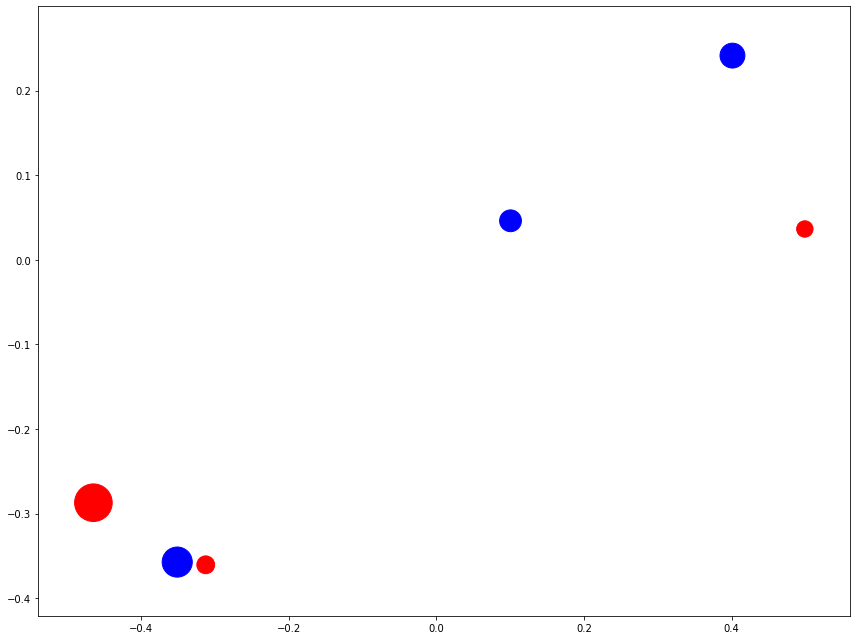

Calculating Sinkhorn divergences over actual points. blur, cluster_scale = 0.0625 0.1
x, y, ranges_x, ranges_y, ranges_xy = tensor([[-0.3508, -0.3574],
        [ 0.1007,  0.0461],
        [ 0.4013,  0.2414]], grad_fn=<CopySlices>) tensor([[-0.3508, -0.3574],
        [ 0.1007,  0.0461],
        [ 0.4013,  0.2414]]) tensor([[0, 1],
        [1, 2],
        [2, 3]], dtype=torch.int32) tensor([[0, 1],
        [1, 2],
        [2, 3]], dtype=torch.int32) None
x, y, ranges_x, ranges_y, ranges_xy = tensor([[-0.4643, -0.2872],
        [-0.3122, -0.3606],
        [ 0.4993,  0.0364]], grad_fn=<CopySlices>) tensor([[-0.4643, -0.2872],
        [-0.3122, -0.3606],
        [ 0.4993,  0.0364]]) tensor([[0, 1],
        [1, 2],
        [2, 3]], dtype=torch.int32) tensor([[0, 1],
        [1, 2],
        [2, 3]], dtype=torch.int32) None
x, y, ranges_x, ranges_y, ranges_xy = tensor([[-0.4643, -0.2872],
        [-0.3122, -0.3606],
        [ 0.4993,  0.0364]], grad_fn=<CopySlices>) tensor([[-0.3508, -0.3574],

In [7]:
import matplotlib.pyplot as plt


scaling, Nits = .5, 9
cluster_scale = .1 if not use_cuda else .05
i = 3
blur = scaling**i

if blur > cluster_scale:
    print('Calculating Sinkhorn divergences over coarse clusters. blur, cluster_scale =', blur, cluster_scale)
else:
    print('Calculating Sinkhorn divergences over actual points. blur, cluster_scale =', blur, cluster_scale)

# Create a copy of the data...
A_i_torch = torch.from_numpy(A_i).type(dtype)
X_i_torch = torch.from_numpy(X_i).contiguous().type(dtype)
B_j_torch = torch.from_numpy(B_j).type(dtype)
Y_j_torch = torch.from_numpy(Y_j).contiguous().type(dtype)
a_i, x_i = A_i_torch.clone(), X_i_torch.clone()
b_j, y_j = B_j_torch.clone(), Y_j_torch.clone()

# And require grad:
a_i.requires_grad = True
x_i.requires_grad = True
b_j.requires_grad = True

# Compute the loss + gradients:
# Loss_p1 = SamplesLoss("sinkhorn", p=1, blur=blur, diameter=1., cluster_scale = cluster_scale,
#                         scaling=scaling, backend="multiscale", verbose=True)
# loss_p1 = Loss_p1(a_i, x_i, b_j, y_j)
Loss_p2 = SamplesLoss("sinkhorn", p=2, blur=blur, diameter=1., cluster_scale = cluster_scale,
                        scaling=scaling, backend="multiscale", verbose=True)
loss_p2 = Loss_p2(a_i, x_i, b_j, y_j)


# print("Loss_p1 =", Loss_p1, "Loss_p2 =", Loss_p2)
# print("loss_p1 =", loss_p1, "loss_p2 =", loss_p2)



plt.figure(figsize=((12, 9)))

size_scale = 2000
ax = plt.scatter(X_i[:, 0], X_i[:, 1], s=size_scale * A_i, c='blue')
ax = plt.scatter(Y_j[:, 0], Y_j[:, 1], s=size_scale * B_j, c='red')


plt.tight_layout()
plt.show()


i = 4
blur = scaling**i

if blur > cluster_scale:
    print('Calculating Sinkhorn divergences over coarse clusters. blur, cluster_scale =', blur, cluster_scale)
else:
    print('Calculating Sinkhorn divergences over actual points. blur, cluster_scale =', blur, cluster_scale)
Loss_p2 = SamplesLoss("sinkhorn", p=2, blur=blur, diameter=1., cluster_scale = cluster_scale,
                        scaling=scaling, backend="multiscale")
loss_p2 = Loss_p2(a_i, x_i, b_j, y_j)

    
    




In [ ]:
plt.figure(figsize=( (12, ((Nits-1)//3 + 1) * 4)))

from pykeops.torch.cluster import grid_cluster, cluster_ranges_centroids
for i in range(Nits):
    blur = scaling**i
    Loss = SamplesLoss("sinkhorn", p=2, blur=blur, diameter=1., cluster_scale = cluster_scale,
                        scaling=scaling, backend="multiscale")

    # Create a copy of the data...
    A_i_torch = torch.from_numpy(A_i).type(dtype)
    X_i_torch = torch.from_numpy(X_i).contiguous().type(dtype)
    B_j_torch = torch.from_numpy(B_j).type(dtype)
    Y_j_torch = torch.from_numpy(Y_j).contiguous().type(dtype)
    a_i, x_i = A_i_torch.clone(), X_i_torch.clone()
    b_j, y_j = B_j_torch.clone(), Y_j_torch.clone()


    # And require grad:
    a_i.requires_grad = True
    x_i.requires_grad = True
    b_j.requires_grad = True

    # Compute the loss + gradients:
    Loss_xy = Loss(a_i, x_i, b_j, y_j)
#     [F_i, G_j, dx_i] = grad( Loss_xy, [a_i, b_j, x_i] )

#     print("F_i.shape, dx_i.shape", F_i.shape, dx_i.shape)
    print("Loss_xy", Loss_xy)
    # The generalized "Brenier map" is (minus) the gradient of the Sinkhorn loss
    # with respect to the Wasserstein metric:
#     BrenierMap = - dx_i / (a_i.view(-1,1) + 1e-7)

    # Compute the coarse measures for display ----------------------------------

    x_lab = grid_cluster(x_i, cluster_scale)
    _, x_c, a_c = cluster_ranges_centroids(x_i, x_lab, weights=a_i)

    y_lab = grid_cluster(y_j, cluster_scale)
    _, y_c, b_c = cluster_ranges_centroids(y_j, y_lab, weights=b_j)


    # Fancy display: -----------------------------------------------------------

    ax = plt.subplot(((Nits-1)//3 + 1) , 3, i+1)
    ax.scatter( [10], [10] )  # shameless hack to prevent a slight change of axis...
    
#     display_potential(ax, G_j, "#E2C5C5")
#     display_potential(ax, F_i, "#C8DFF9")


#     if blur > cluster_scale:
#         display_samples(ax, y_j, b_j, [(.55,.55,.95, .2)])
#         display_samples(ax, x_i, a_i, [(.95,.55,.55, .2)], v = BrenierMap)
#         display_samples(ax, y_c, b_c, [(.55,.55,.95)])
#         display_samples(ax, x_c, a_c, [(.95,.55,.55)])

#     else:
#     display_samples(ax, y_j, b_j, [(.55,.55,.95)])
#     display_samples(ax, x_i, a_i, [(.95,.55,.55)])#, v = BrenierMap)


    ax.set_title("iteration {}, blur = {:.3f}".format(i+1, blur))

    ax.set_xticks([0, 1]) ; ax.set_yticks([0, 1])
    ax.axis([0,1,0,1]) ; ax.set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()
